In [1]:
import os
import multiprocessing as mp
from functools import reduce, partial

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [3]:
import pandas as pd
import scipy
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

from typing import List, Dict, NoReturn, Any, Callable, Union, Optional
import copy
import gc
import multiprocessing as mp

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.decomposition import PCA
from sklearn import preprocessing

In [4]:
print(plt.style.available)
styles = plt.style.available

['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'bmh', 'tableau-colorblind10', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep']


In [5]:
%matplotlib inline
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (15, 8)

In [6]:
def time_indexed_df(df1: pd.core.frame.DataFrame, columname: str) -> pd.core.frame.DataFrame:
    """ 
        Cast into a time-indexed dataframe.
        df1 paramater should have a column containing datetime-like data,
        which contains entries of type pandas._libs.tslibs.timestamps.Timestamp
        or a string containing a compatible datetime (i.e. pd.to_datetime)
    """
    
    _tmp = df1.copy()
    
    pool = mp.Pool()
    _tmp[columname] = pool.map(pd.to_datetime, _tmp[columname])
    pool.close()
    pool.terminate()
    
    _tmp.index = _tmp[columname]
    _tmp.drop(columname, axis=1, inplace=True)
    _tmp = _tmp.sort_index()
    
    return _tmp
##

def dist_plot(series: pd.core.series.Series, dropna: bool = True) -> NoReturn:
    """
        Given a pandas Series, generate a descriptive visualisation 
        with a boxplot and a histogram with a kde.
        By default, this function drops `nan` values. If you desire to
        handle them differently, you should do so beforehand and/or
        specify dropna=False.
    """
    
    if dropna:
        series = series.dropna()
    
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.25, .75)})
    sns.boxplot(series, ax=ax_box)
    sns.stripplot(series, color="orange", jitter=0.2, size=2.5, ax=ax_box)
    sns.distplot(series, ax=ax_hist, kde=True)
    ax_box.set(xlabel='')
##


def merge_on_duplicate_idx(
    df: pd.core.frame.DataFrame, 
    mask: Any = np.nan,
    verbose: bool = False
) -> pd.core.frame.DataFrame:
    """
    """
    
    y = df.copy()
    y = y.mask( y == mask ).groupby(level=0).first()
    
    if verbose:
        original_rows = df.shape[0]
        duplicate_idx = df[df.index.duplicated(keep=False)].index
        duplicate_rows = df.loc[duplicate_idx].shape[0]
        new_rows = y.shape[0]
        print(f" Total rows on source dataframe :\t{original_rows}")
        print(f" Duplicate indices :\t\t\t{duplicate_idx.shape[0]}")
        print(f" Total duplicate rows :\t\t\t{duplicate_rows}")
        print(f" Rows on pruned dataframe :\t\t{new_rows}")
    
    return y
##

def comparative_hba1c_plot(
    df: pd.core.frame.DataFrame,
    colum_name: str = "Sensor Glucose (mg/dL)",
    hba1c: Callable = lambda x: (x + 105) / 36.5,
    windows: Dict[str,int] = {
        "weekly": 7,
        "monthly": 30
    }
) -> NoReturn:
    """
        
    """
    df.groupby(df.index.dayofyear)[colum_name].mean().apply(hba1c).plot(**{"label":"daily"})
    for key, value in windows.items():
        df.groupby(df.index.dayofyear)[colum_name].mean().rolling(value).mean().apply(hba1c).plot(**{"label":key})
    mean_hba1c = hba1c(df[colum_name].mean()) 
    plt.axhline(mean_hba1c, **{"label": f"mean = {round(mean_hba1c,1)}", "c": "blue"})
    plt.legend()
##

def probability_estimate(
    data: pd.core.series.Series, 
    start: float, 
    end: float, 
    N: int = 250,
    percentage: bool = False,
    show_plots: bool = False
) -> float:
    """
        buggy.
    """
    
    # Plot the data using a normalized histogram
    dev = copy.deepcopy(data)
    dev = dev.dropna().apply(int)
    
    x = np.linspace(dev.min(), min(data), max(data))[:, np.newaxis]

    # Do kernel density estimation
    kd = KernelDensity(kernel='gaussian', bandwidth=0.85).fit(np.array(dev).reshape(-1, 1))

    # Plot the estimated densty
    kd_vals = np.exp(kd.score_samples(x))

    # Show the plots
    if show_plots:
        plt.plot(x, kd_vals)
        plt.hist(dev, 50, normed=True)
        plt.xlabel('Concentration mg/dl')
        plt.ylabel('Density')
        plt.title('Probability Density Esimation')
        plt.show()

    #probability = integrate(lambda x: np.exp(kd.score_samples(x.reshape(-1, 1))), start, end)[0]
    
    # Integration :
    step = (end - start) / (N - 1)  # Step size
    x = np.linspace(start, end, N)[:, np.newaxis]  # Generate values in the range
    kd_vals = np.exp(kd.score_samples(x))  # Get PDF values for each x
    probability = np.sum(kd_vals * step)  # Approximate the integral of the PDF
    
    if percentage:
        probability *= 100
    
    return probability
##

def hybrid_interpolator(
    data: pd.core.series.Series,
    mean: float = None,
    limit: float = None,
    methods: List[str] = ['linear', 'spline'], 
    weights: List[float] = [0.65, 0.35],
    direction: str = 'forward',
    order: int = 2
) -> pd.core.series.Series:
    """
    Return a pandas.core.series.Series instance resulting of the weighted average
    of two interpolation methods.
    
    Model:
        φ = β1*method1 + β2*method2
        
    Default:
        β1, β2 = 0.6, 0.4
        method1, method2 = linear, spline
    
    Weights are meant to be numbers from the interval (0, 1)
    which add up to one, to keep the weighted sum consistent.
    
    limit_direction : {‘forward’, ‘backward’, ‘both’}, default ‘forward’
    If limit is specified, consecutive NaNs will be filled in this direction.
    
    If the predicted φ_i value is outside of the the interval
    ( (mean - limit), (mean + limit) )
    it will be replaced by the linear interpolation approximation.
    
    If not set, mean and limit will default to:
        mean = data.mean()
        limit = 2 * data.std()
    
    This function should have support for keyword arguments, but is yet to be implemented.
    """
    predictions: List[float] = [] 
    
    if not np.isclose(sum(weight for weight in weights), 1):
        raise Exception('Sum of weights must be equal to one!')
    
    for met in methods:
        if (met == 'spline') or (met == 'polynomial'):
            predictions.append(data.interpolate(method=met, order=order, limit_direction=direction))
        else:
            predictions.append(data.interpolate(method=met, limit_direction=direction))

    linear: pd.core.series.Series = predictions[0]
    spline: pd.core.series.Series = predictions[1]
    hybrid: pd.core.series.Series = weights[0]*predictions[0] + weights[1]*predictions[1]
    
    corrected: pd.core.series.Series = copy.deepcopy(hybrid) 
    
    if not mean:
        mean = data.mean()
    if not limit:
        limit = 2 * data.std()
    
    for idx, val in zip(hybrid[ np.isnan(data) ].index, hybrid[ np.isnan(data) ]):
        if (val > mean + limit) or (val < mean - limit):
            corrected[idx] = linear[idx]
    
    #df = copy.deepcopy(interpolated)
    #print(df.isnull().astype(int).groupby(df.notnull().astype(int).cumsum()).sum())
    
    return corrected
##

### HBA1C%
The gold standard for diabetes diagnosis and evaluation of its therapy. See the [Mayo clinic's page on HBA1C](https://www.mayocliniclabs.com/test-catalog/Clinical+and+Interpretive/82080)

In [7]:
hba1c = lambda x: (x + 105) / 36.5

In [8]:
#get_duplicate_idx = lambda w: w[w.index.duplicated(keep=False)].index

In [9]:
get_csv_files = lambda loc: [os.path.join(loc, x) for x in os.listdir(loc) if x[-4:] == ".csv"] 

In [15]:
files = get_csv_files("data/apr/")
files

['data/apr/CareLink-Export-15-apr-2020-1-month.csv',
 'data/apr/CareLink-Export-15-apr-2020-15-days.csv',
 'data/apr/CareLink-Export-15-apr-2020-3-month.csv']

In [16]:
the_file = files[-1]
x = pd.read_csv(the_file)
# x.columns

/usr/local/anaconda3/envs/diab/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (3,8,9,10,13,14,16,17,18,32,34,37,39,41,44) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Read the csv file, and inspect the columns. Our ```time_indexed_df``` function requires a single column containing "Datetime". For this purpose we calculate it by concatenating the **Date** and **Time** columns from the csv.

In [17]:
x["DateTime"] =  x["Date"] + " " + x["Time"]
x.drop(["Date", "Time"], axis=1, inplace=True)

In [18]:
x.head(3)

,Index,New Device Time,BG Reading (mg/dL),Linked BG Meter ID,Basal Rate (U/h),Temp Basal Amount,Temp Basal Type,Temp Basal Duration (h:mm:ss),Bolus Type,Bolus Volume Selected (U),...,Insulin Action Curve Time,Sensor Calibration Rejected Reason,Preset Bolus,Bolus Source,Network Device Associated Reason,Network Device Disassociated Reason,Network Device Disconnected Reason,Sensor Exception,Preset Temp Basal Name,DateTime
0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020/04/15 13:16:31
1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020/04/15 13:15:47
2,2.0,NaN,96.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020/04/15 13:08:22


Here we create a *date_time-indexed dataframe*. Afterwards we drop the original, useless, "Index" column. We then merge on duplicate indices as the Pump system logs a separate entry for each event, even when they occur simultaneously.

In [19]:
y = time_indexed_df(x, 'DateTime')
y.drop("Index", axis=1, inplace=True)
# experimental  
y.index = y.index.map(lambda t: t.replace(second=0))
# end experimental
y = merge_on_duplicate_idx(y, verbose=True)
z = y.copy()

 Total rows on source dataframe :	34185
 Duplicate indices :			11127
 Total duplicate rows :			32865
 Rows on pruned dataframe :		27374


In [20]:
# TMP !
z = y.loc["2020-03-12":"2020-03-27", :]

If you would like to better understand the *merge* mechanism, uncomment the following code snippet, index the dataframe on the pertinent indices (```duplicate_idx``` variable).

In [21]:
# Removing duplicates : 
"""
duplicate_idx = y[y.index.duplicated(keep=False)].index
print(duplicate_idx.shape)
y = y.mask( y == np.nan ).groupby(level=0).first()
"""

'\nduplicate_idx = y[y.index.duplicated(keep=False)].index\nprint(duplicate_idx.shape)\ny = y.mask( y == np.nan ).groupby(level=0).first()\n'

In [22]:
# Remove unnecessary seconds resolution from datetime-index : 
#y.index = y.index.map(lambda t: t.replace(second=0))

In [23]:
pd.infer_freq(y.index)
adv_methods = ['krogh', 'piecewise_polynomial', 'spline', 'pchip', 'akima']

In [24]:
#help(hybrid_interpolator)

In [26]:
#clip = pd.read_clipboard(sep='\s\s+')
#clip.index = clip.index.map(pd.to_datetime)

In [27]:
#clip.index.to_series().diff(1) > dt.timedelta(minutes=45)

In [28]:
#clip.index

In [29]:
w = z.loc[:, ["Sensor Glucose (mg/dL)", "ISIG Value"]]#.resample("1T").asfreq()
#v = w.interpolate(method=adv_methods[-4], order=4)
v = hybrid_interpolator(
    w["Sensor Glucose (mg/dL)"],
    weights=[0.5, 0.5]
)

In [30]:
w.loc['2020-03-16 16:31:00':'2020-03-16 19:30:00', ["Sensor Glucose (mg/dL)", "ISIG Value"]]

,Sensor Glucose (mg/dL),ISIG Value
DateTime,,
2020-03-16 16:31:00,116.0,17.60
2020-03-16 16:36:00,110.0,16.26
2020-03-16 16:41:00,112.0,18.66
2020-03-16 16:46:00,121.0,21.86
2020-03-16 16:51:00,124.0,20.67
2020-03-16 16:56:00,NaN,NaN
2020-03-16 17:00:00,NaN,NaN
2020-03-16 17:01:00,116.0,15.86
2020-03-16 17:06:00,108.0,14.99


In [31]:
start = "2020-03-16 9:35"
stop  = "2020-03-17 19:45"

In [32]:
#help(pd.core.frame.DatetimeIndex.to_series)

In [33]:
#dir(w.index)
indices_df = pd.DataFrame(w.index.to_series(name="Index"))
indices_df["Deltas"] = indices_df.Index.diff(1)
indices_df["Cutoff"] = indices_df.Deltas > dt.timedelta(minutes=45)
indices_df.Cutoff[indices_df.Cutoff == True].index.to_list()

[Timestamp('2020-03-16 19:00:00'),
 Timestamp('2020-03-17 11:00:00'),
 Timestamp('2020-03-17 13:00:00'),
 Timestamp('2020-03-23 12:00:00'),
 Timestamp('2020-03-23 13:00:00'),
 Timestamp('2020-03-23 13:52:00')]

In [34]:
indices_df["Deltas"] = indices_df.Index.diff(1)

In [39]:
greater_than_half = indices_df["Deltas"] > dt.timedelta(minutes=45)

In [40]:
jumps = greater_than_half[greater_than_half == True].index.to_list()
jumps

[Timestamp('2020-03-16 19:00:00'),
 Timestamp('2020-03-17 11:00:00'),
 Timestamp('2020-03-17 13:00:00'),
 Timestamp('2020-03-23 12:00:00'),
 Timestamp('2020-03-23 13:00:00'),
 Timestamp('2020-03-23 13:52:00')]

In [41]:
#w.index
g = w.applymap(lambda x: int(x) if not np.isnan(x) else x).groupby("ISIG Value")
g

In [42]:
g = w.groupby(level=0, by=jumps)

In [43]:
for i, j in g:
    pass
    #print(i)
    #print(j.shape)

In [44]:
g = w.index.groupby(jumps)

In [45]:
keys = list(g.keys())

In [46]:
g[keys[0]]

DatetimeIndex(['2020-03-12'], dtype='datetime64[ns]', name='DateTime', freq=None)

In [47]:
#w.loc[g[], :]

In [48]:
#for cut_date, split_df in w.groupby(jumps, axis=0):
    #print(cut_date)

In [49]:
#help(pd.DataFrame.groupby)

In [50]:
#help(pd.DataFrame.between_time)

In [51]:
cutter

NameError: name 'cutter' is not defined

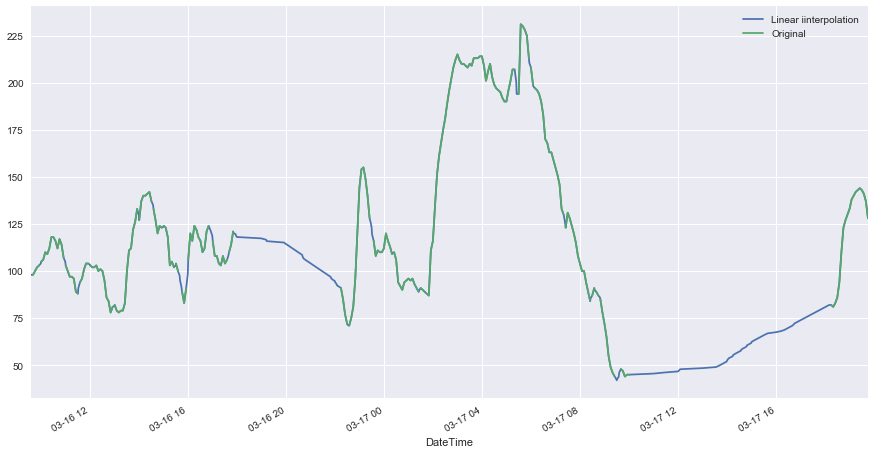

In [53]:
#v.loc[start:stop].plot()
z.loc[start:stop, "Sensor Glucose (mg/dL)"].interpolate().plot(label='Linear iinterpolation')
z.loc[start:stop, "Sensor Glucose (mg/dL)"].plot(label='Original')
#z.loc[star
plt.legend()

In [54]:
z["Sensor Glucose (mg/dL)"].dropna().index == w["Sensor Glucose (mg/dL)"].dropna().index

array([ True,  True,  True, ...,  True,  True,  True])

In [55]:
start2 = "2020-03-13"
stop2  = "2020-03-16"

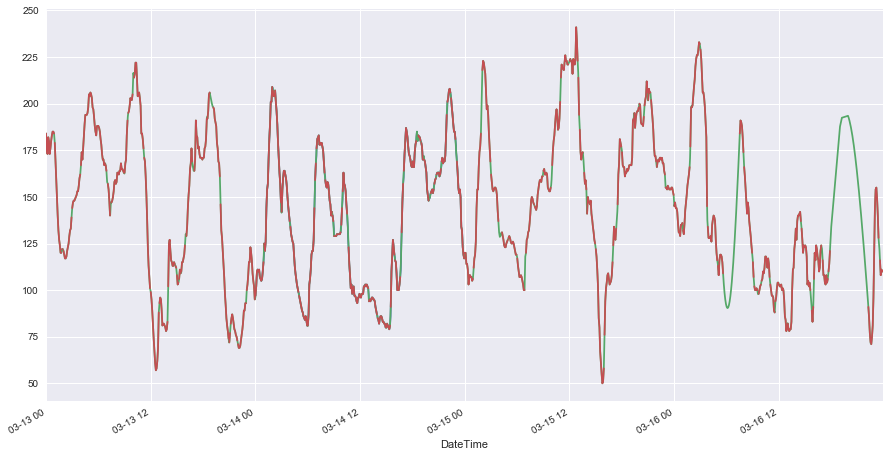

In [56]:
z.loc["2020-03-14":"2020-03-14", "Sensor Glucose (mg/dL)"].interpolate("linear").plot()
z.loc[start2:stop2, "Sensor Glucose (mg/dL)"].interpolate("cubic").plot()
z.loc[start2:stop2, "Sensor Glucose (mg/dL)"].plot()

In [57]:
#help(y.resample)
#w = y.resample("1T").apply(lambda x: x)

In [58]:
#dir(y.index)

In [59]:
y.index[:10], w.index[:10]

(DatetimeIndex(['2020-01-20 04:52:00', '2020-01-20 04:57:00',
                '2020-01-20 05:02:00', '2020-01-20 05:07:00',
                '2020-01-20 05:12:00', '2020-01-20 05:17:00',
                '2020-01-20 05:22:00', '2020-01-20 05:27:00',
                '2020-01-20 05:32:00', '2020-01-20 05:37:00'],
               dtype='datetime64[ns]', name='DateTime', freq=None),
 DatetimeIndex(['2020-03-12 00:00:00', '2020-03-12 00:01:00',
                '2020-03-12 00:06:00', '2020-03-12 00:11:00',
                '2020-03-12 00:16:00', '2020-03-12 00:21:00',
                '2020-03-12 00:26:00', '2020-03-12 00:27:00',
                '2020-03-12 00:31:00', '2020-03-12 00:36:00'],
               dtype='datetime64[ns]', name='DateTime', freq=None))

In [60]:
y.loc[meal_id, :].shape, w.loc[meal_id, :].shape

NameError: name 'meal_id' is not defined

In [61]:
# Useful having an hour column, for groupby opperations :
y['hour'] = y.index.hour
# Deltas within valuable intervals : 
for i in [10, 20, 30]: 
    y[f'd{i}'] = y['Sensor Glucose (mg/dL)'].diff(i)

The previous code snippet generates *delta* columns. These are, however, suboptimal as logging seems to be inconsistent. This may be fixed via interpolation, but precaution is mandatory.

The following attemps to *map* the hours and minutes from the datetime index to a [parametric circle](https://mathopenref.com/coordparamcircle.html). You might ask : **Why?**

The insulin pump is configured to adjust the hourly basal dose of insulin. In general, a healthy pancreas would constantly secrete insulin responding to subtle variations in glycaemia. When there is a carb intake, i.e. a the person eats something such as bread, fruit, etc. glycaemia rises and this augmentation frees insulin to the bloodstream.

Insulin sensibility varies throughout the day. The previously mentioned pump configuration has scheduled basal doses and **insulin-glycaemia-drop ratio, a.k.a insulin sensitivity** and **insulin-carbohidrate absorption ratio, alias carb ratio**.

To better represent this periodicity, I've decided to create this two new periodic variables as the sine and cosine of the hour and minute of the day. This enables the expression of the periodicity of physiological phenomena, i.e. today's midnight is closer to tomorrow's morning than it is to the same day's morning.

In [62]:
T = 1439
min_res_t_series = pd.Series(y.hour*60 + y.index.minute)
y['x(t)'] = min_res_t_series.apply(lambda x: np.cos(2*np.pi*(x) / T))
y['y(t)'] = min_res_t_series.apply(lambda x: np.sin(2*np.pi*(x) / T))
# sns.scatterplot(x="x(t)", y="y(t)", data=y)

In [63]:
#y.columns

In [64]:
idx = y['Sensor Glucose (mg/dL)'].dropna().index
#y.loc[idx, ['Sensor Glucose (mg/dL)', 'd10', 'd20'] ].head(25)

In [65]:
whole = y.copy()

In [66]:
whole['ISIG Value'].dropna().count(), whole['Sensor Glucose (mg/dL)'].dropna().count()

(22174, 22174)

We can perform regression as we have as many ISIG values as Glucose sensor readings. This is however a bit discouraging as it implies that the pump stops logging ISIG values when a calibration deadline is missed, I'm talking from experience.

In [67]:
"""
bg_idx = whole['BG Reading (mg/dL)'].dropna().index
whole.loc[
    bg_idx - dt.timedelta(minutes=10) : bg_idx + dt.timedelta(minutes=10)
    , 'Sensor Glucose (mg/dL)'
]
"""

"\nbg_idx = whole['BG Reading (mg/dL)'].dropna().index\nwhole.loc[\n    bg_idx - dt.timedelta(minutes=10) : bg_idx + dt.timedelta(minutes=10)\n    , 'Sensor Glucose (mg/dL)'\n]\n"

In [68]:
hba1c(whole['Sensor Glucose (mg/dL)'].dropna().mean())

6.86237862188346

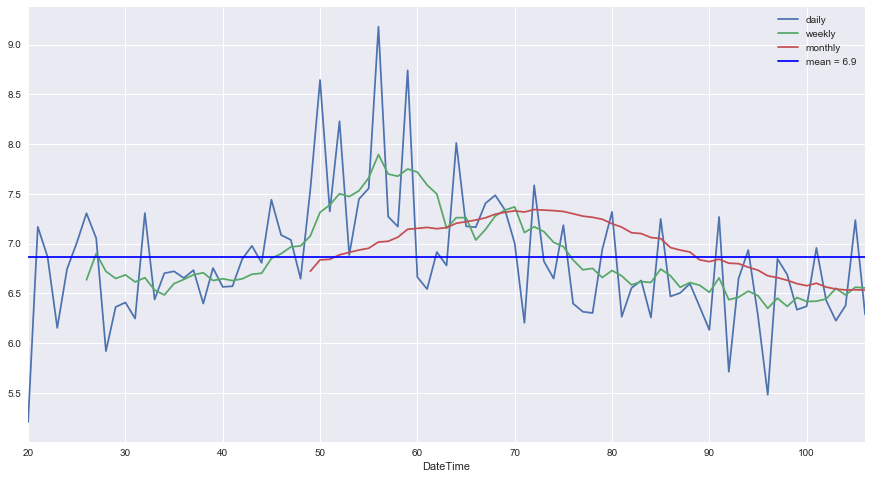

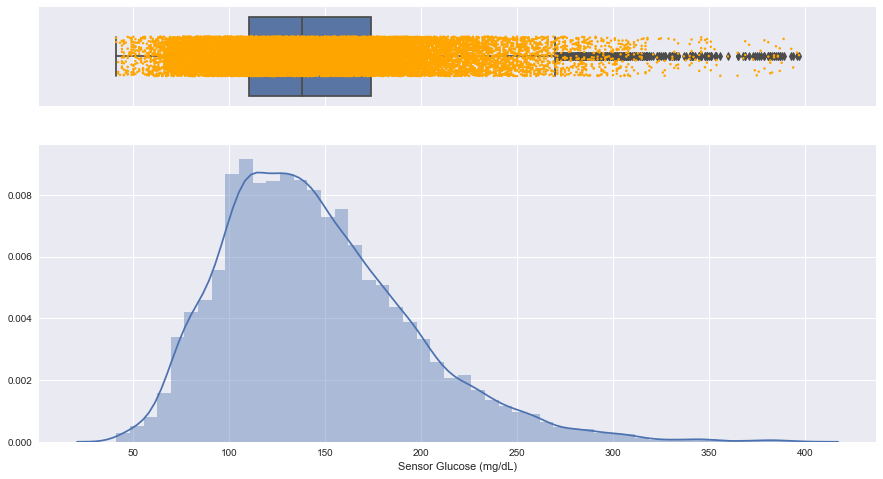

In [69]:
comparative_hba1c_plot(whole)
dist_plot(whole['Sensor Glucose (mg/dL)'])

# Last 15 days

In [94]:
y = whole.loc["2020-03-01":"2020-04-15", :]

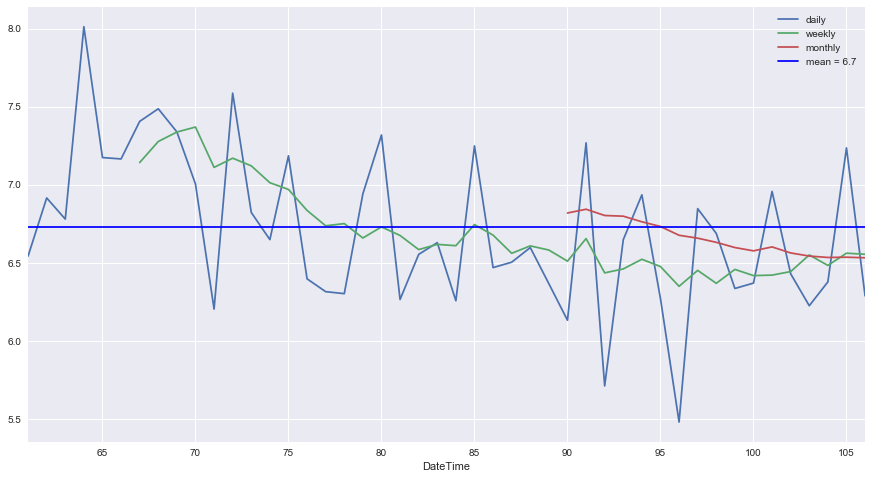

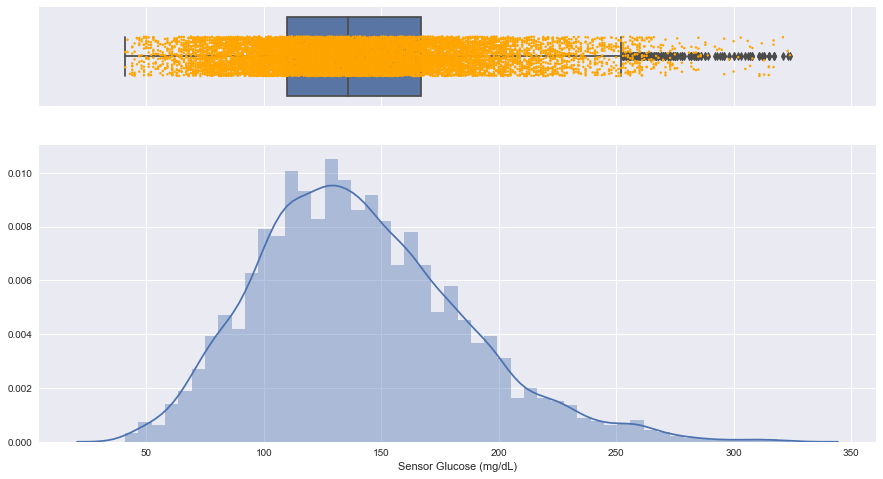

In [95]:
comparative_hba1c_plot(y)
dist_plot(y['Sensor Glucose (mg/dL)'])

In [74]:
# This is commented out as this function has a bug.
#probability_estimate(y["Sensor Glucose (mg/dL)"], 150, 300, percentage=True)

In [75]:
#y["Sensor Glucose (mg/dL)"].dropna().apply(int)

In [76]:
#"dropna" in dir(pd.Series)

## Hypoglycaemia pattern detection

In [77]:
keyword = 'SUSPEND BEFORE LOW'
alarms  = []
for i in y.Alarm.dropna().unique().tolist():
    if keyword in i:
        alarms.append(i)
alarms

['SUSPEND BEFORE LOW ALARM, QUIET',
 'SUSPEND BEFORE LOW ALARM, PATIENT UNRESPONSIVE, MEDICAL DEVICE EMERGENCY']

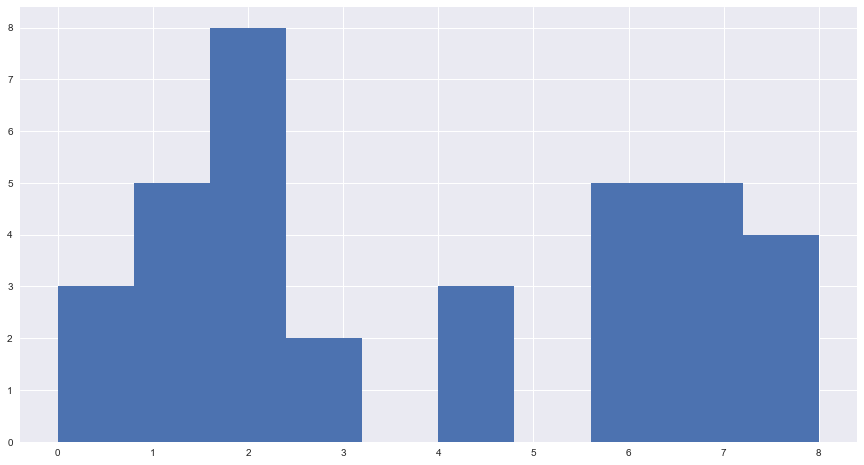

In [78]:
y[ y.Alarm == 'SUSPEND BEFORE LOW ALARM, QUIET' ].hour.hist()

In [79]:
#meal_id = y['BWZ Carb Input (grams)'].dropna().index
nonull_meals = y['BWZ Carb Input (grams)'].dropna()
nonull_meals = nonull_meals[ nonull_meals > 0 ]
meal_id = nonull_meals.index
print(len(meal_id))
meal_id[:5]

52


DatetimeIndex(['2020-04-01 10:40:00', '2020-04-01 16:33:00',
               '2020-04-01 22:13:00', '2020-04-02 10:42:00',
               '2020-04-02 15:52:00'],
              dtype='datetime64[ns]', name='DateTime', freq=None)

In [80]:
nonull_corrections = y['BWZ Correction Estimate (U)'].dropna()
nonull_corrections = nonull_corrections[ nonull_corrections > 0 ]
corrections_id = nonull_corrections.index
print(len(corrections_id))
corrections_id[:5]

58


DatetimeIndex(['2020-04-01 08:31:00', '2020-04-01 10:40:00',
               '2020-04-01 22:13:00', '2020-04-02 03:42:00',
               '2020-04-02 09:58:00'],
              dtype='datetime64[ns]', name='DateTime', freq=None)

In [81]:
bolus_id = corrections_id.union(meal_id)
print(len(bolus_id))

84


In [82]:
basal = y.copy()
for uid in bolus_id:
    real = uid+dt.timedelta(hours=2, minutes=30)
    closest = y.index[y.index.searchsorted(real) - 1]  # Otherwise it goes out of bounds !
    basal.loc[uid:closest, 'Sensor Glucose (mg/dL)'] = np.nan

In [83]:
y.columns

Index(['New Device Time', 'BG Reading (mg/dL)', 'Linked BG Meter ID',
       'Basal Rate (U/h)', 'Temp Basal Amount', 'Temp Basal Type',
       'Temp Basal Duration (h:mm:ss)', 'Bolus Type',
       'Bolus Volume Selected (U)', 'Bolus Volume Delivered (U)',
       'Bolus Duration (h:mm:ss)', 'Prime Type', 'Prime Volume Delivered (U)',
       'Alarm', 'Suspend', 'Rewind', 'BWZ Estimate (U)',
       'BWZ Target High BG (mg/dL)', 'BWZ Target Low BG (mg/dL)',
       'BWZ Carb Ratio (g/U)', 'BWZ Insulin Sensitivity (mg/dL/U)',
       'BWZ Carb Input (grams)', 'BWZ BG Input (mg/dL)',
       'BWZ Correction Estimate (U)', 'BWZ Food Estimate (U)',
       'BWZ Active Insulin (U)', 'Sensor Calibration BG (mg/dL)',
       'Sensor Glucose (mg/dL)', 'ISIG Value', 'Event Marker', 'Bolus Number',
       'Bolus Cancellation Reason', 'BWZ Unabsorbed Insulin Total (U)',
       'Final Bolus Estimate', 'Scroll Step Size', 'Insulin Action Curve Time',
       'Sensor Calibration Rejected Reason', 'Preset Bol

In [84]:
bolus = pd.DataFrame(columns=['Sensor Glucose (mg/dL)', 'ISIG Value', 'hour', 'd10', 'd20', 'd30', 'x(t)', 'y(t)'], index=y.index)

In [85]:
for uid in bolus_id:
    real = uid+dt.timedelta(hours=2, minutes=30)
    closest = y.index[y.index.searchsorted(real) - 1]  # Otherwise it goes out of bounds !
    bolus.loc[uid:closest, bolus.columns] = y.loc[uid:closest, bolus.columns]

In [86]:
#sns.pairplot(bolus.loc[ bolus["Sensor Glucose (mg/dL)"].dropna().index, : ])
#bolus["Sensor Glucose (mg/dL)"].groupby(clean_index.hour).mean().plot()

In [87]:
y.loc[bolus_id[5], bolus.columns]

Sensor Glucose (mg/dL)         NaN
ISIG Value                     NaN
hour                             9
d10                            NaN
d20                            NaN
d30                            NaN
x(t)                     -0.862548
y(t)                      0.505975
Name: 2020-04-02 09:58:00, dtype: object

In [88]:
show = False
if show:
    y.loc['2020-03-15', 'Sensor Glucose (mg/dL)'].plot(**{"label": "Full"})
    basal.loc['2020-03-15', 'Sensor Glucose (mg/dL)'].plot(**{"label": "basal"})
    plt.legend()

In [89]:
#basal.groupby(basal.index.hour)['Sensor Glucose (mg/dL)'].mean().plot()

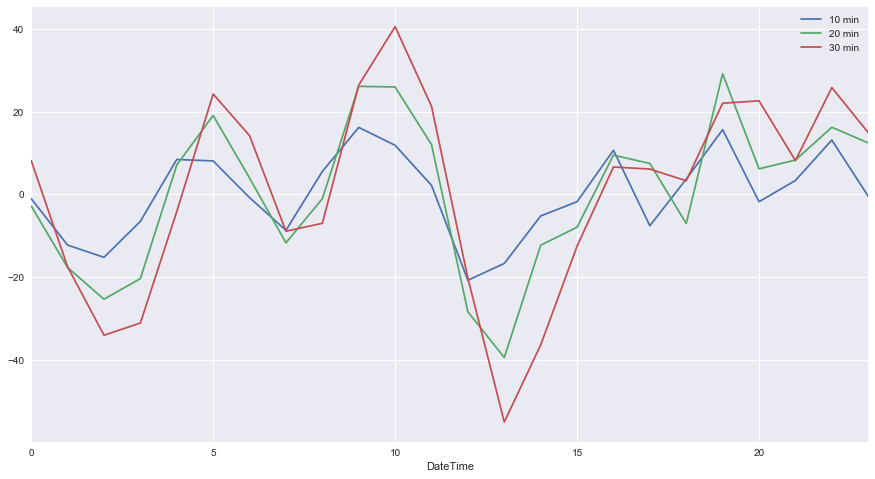

In [90]:
figs = [basal.groupby(basal.index.hour)[f'd{i}'].mean().plot(label=f"{i} min") for i in [10, 20, 30]]
figs[-1].legend()

In [91]:
#help(pd.Series.interpolate)

In [92]:
methods = [
    'nearest', 'zero', 'slinear', 'quadratic', 'cubic', 'spline', 'barycentric', 'polynomial',
    'krogh', 'piecewise_polynomial', 'spline', 'pchip', 'akima'
]

In [93]:
(
  lambda w: y.loc['2020-03-14 09:00':'2020-03-14 21:00', 'Sensor Glucose (mg/dL)'].interpolate(method=w).plot(label=w)
)(methods[6])
y.loc['2020-03-14 09:00':'2020-03-14 21:00', 'Sensor Glucose (mg/dL)'].plot(label="Original")
plt.legend()

TypeError: no numeric data to plot

In [57]:
abs(dt.timedelta(hours=1) - dt.timedelta(hours=2))

datetime.timedelta(seconds=3600)

In [26]:
y.loc[meal_id, 'BWZ Carb Ratio (g/U)'].dropna().index ==  meal_id

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

In [27]:
dt10 = dt.timedelta(minutes=10)
dtpost_low = dt.timedelta(hours=1, minutes=40)
dtpost_high = dt.timedelta(hours=2, minutes=20)

In [28]:
meal_descriptive = pd.core.frame.DataFrame({
    'hour': meal_id.hour, 
    'pre prandial': [ 
        y.loc[ meal - dt10 : meal + dt10,  'Sensor Glucose (mg/dL)' ].dropna().mean()
        for meal in meal_id
    ],
    'post mean': [
        y.loc[ meal + dtpost_low : meal + dtpost_high, 'Sensor Glucose (mg/dL)'].dropna().mean() 
        for meal in meal_id
    ],
    'post std': [
        y.loc[ meal + dtpost_low : meal + dtpost_high, 'Sensor Glucose (mg/dL)'].dropna().std() 
        for meal in meal_id
    ], 
    'post min': [
        y.loc[ meal + dtpost_low : meal + dtpost_high, 'Sensor Glucose (mg/dL)'].dropna().min() 
        for meal in meal_id
    ],
    'post max': [
        y.loc[ meal + dtpost_low : meal + dtpost_high, 'Sensor Glucose (mg/dL)'].dropna().max() 
        for meal in meal_id
    ],
}, index=meal_id)

meal_descriptive['delta'] = meal_descriptive['post mean'] - meal_descriptive['pre prandial'] 
meal_descriptive['ratio'] = y.loc[meal_id, 'BWZ Carb Ratio (g/U)'].dropna()

In [29]:
meal_descriptive.loc[  meal_descriptive.hour < 6, 'meal' ] = 'night'
meal_descriptive.loc[ (meal_descriptive.hour >= 6)  & (meal_descriptive.hour < 9), 'meal'  ] = 'breakfast'
meal_descriptive.loc[ (meal_descriptive.hour >= 9)  & (meal_descriptive.hour < 12), 'meal' ] = 'lunch'
meal_descriptive.loc[ (meal_descriptive.hour >= 12) & (meal_descriptive.hour < 19), 'meal' ] = 'afternoon'
meal_descriptive.loc[ (meal_descriptive.hour >= 19) & (meal_descriptive.hour < 24), 'meal' ] = 'dinner'

In [30]:
meal_descriptive.head()

,hour,pre prandial,post mean,post std,post min,post max,delta,ratio,meal
DateTime,,,,,,,,,
2020-03-01 14:14:54,14,172.50,77.250,29.605743,44.0,130.0,-95.250,12.0,afternoon
2020-03-01 17:49:28,17,173.00,185.625,8.140507,175.0,194.0,12.625,12.0,afternoon
2020-03-01 19:25:28,19,191.25,169.000,26.164316,130.0,198.0,-22.250,18.0,dinner
2020-03-01 22:57:47,22,93.75,149.750,11.196300,136.0,162.0,56.000,18.0,dinner
2020-03-02 01:36:59,1,126.00,197.375,5.449443,191.0,206.0,71.375,12.0,night


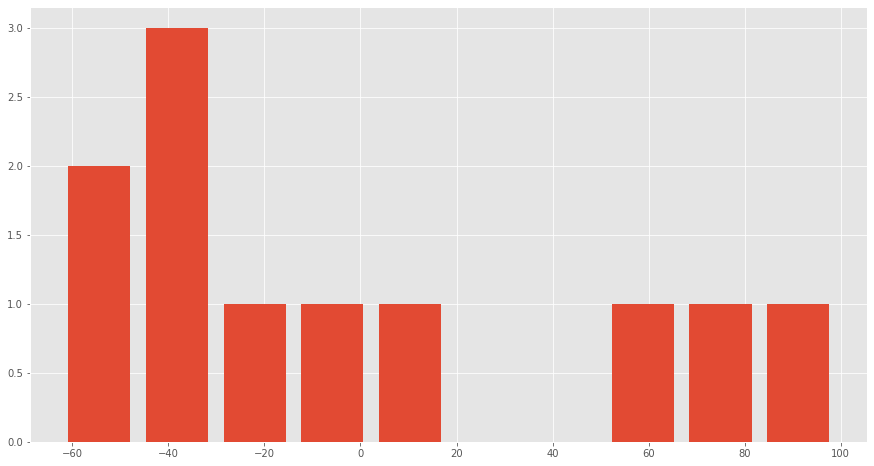

In [31]:
meal_descriptive[ meal_descriptive.meal ==  'lunch' ].delta.hist(rwidth=0.8)

In [32]:
print(meal_descriptive[ meal_descriptive.meal == 'dinner'].describe())

            hour  pre prandial   post mean   post std    post min    post max  \
count  21.000000     18.000000   18.000000  18.000000   18.000000   18.000000   
mean   21.380952    127.458333  133.958333  10.228222  120.722222  148.555556   
std     1.465476     36.808552   41.451003   7.646826   40.731265   42.541637   
min    19.000000     73.750000   80.250000   1.908627   68.000000   87.000000   
25%    20.000000     98.625000  114.750000   5.391793  106.500000  128.000000   
50%    22.000000    125.000000  128.687500   8.246022  118.500000  138.500000   
75%    22.000000    147.125000  148.156250  11.079633  129.750000  160.750000   
max    23.000000    191.250000  246.750000  26.672618  242.000000  254.000000   

            delta      ratio  
count   17.000000  21.000000  
mean     8.926471  18.190476  
std     54.214293   0.402374  
min    -64.875000  18.000000  
25%    -42.000000  18.000000  
50%      5.375000  18.000000  
75%     55.375000  18.000000  
max    101.500000  19.

In [33]:
meal_descriptive.head()

,hour,pre prandial,post mean,post std,post min,post max,delta,ratio,meal
DateTime,,,,,,,,,
2020-03-01 14:14:54,14,172.50,77.250,29.605743,44.0,130.0,-95.250,12.0,afternoon
2020-03-01 17:49:28,17,173.00,185.625,8.140507,175.0,194.0,12.625,12.0,afternoon
2020-03-01 19:25:28,19,191.25,169.000,26.164316,130.0,198.0,-22.250,18.0,dinner
2020-03-01 22:57:47,22,93.75,149.750,11.196300,136.0,162.0,56.000,18.0,dinner
2020-03-02 01:36:59,1,126.00,197.375,5.449443,191.0,206.0,71.375,12.0,night


In [34]:
column    = 'delta'

print(column, '\n')
for i in set(meal_descriptive.meal):
    _tmp =  meal_descriptive[ meal_descriptive.meal == i ].describe().T
    print(i, '\n', f"Mean: {int(_tmp['mean'][column])}, Std: {int(_tmp['std'][column])}", '\n\n')

delta 

night 
 Mean: -9, Std: 75 


dinner 
 Mean: 8, Std: 54 


lunch 
 Mean: 0, Std: 55 


afternoon 
 Mean: 3, Std: 54 


breakfast 
 Mean: 31, Std: 20 




In [35]:
postp = [
    y.loc[ 
        meal + dt.timedelta(hours=1, minutes=30) : meal + dt.timedelta(hours=3), 
        ['Sensor Glucose (mg/dL)', 'hour', *[f'd{i}' for i in range(1, 11)]] 
    ].dropna()
    for meal in meal_id
]

postp = pd.concat(postp)
postp.rename({
    'Sensor Glucose (mg/dL)': 'post points', 'b': 'Y'
}, axis='columns', inplace=True)

postp.head()

,post points,hour,d1,d2,d3,d4,d5,d6,d7,d8,d9,d10
DateTime,,,,,,,,,,,,
2020-03-01 15:53:58,139.0,15,-6.0,-20.0,-25.0,-29.0,-42.0,-48.0,-51.0,-48.0,-51.0,-48.0
2020-03-01 15:58:58,130.0,15,-9.0,-15.0,-29.0,-34.0,-38.0,-51.0,-57.0,-60.0,-57.0,-60.0
2020-03-01 20:58:58,196.0,20,-1.0,0.0,0.0,-1.0,-1.0,-2.0,0.0,4.0,2.0,3.0
2020-03-02 00:53:59,154.0,0,-6.0,-8.0,-8.0,-9.0,-10.0,-10.0,-11.0,-10.0,-8.0,-5.0
2020-03-02 17:58:59,204.0,17,74.0,-4.0,70.0,-4.0,69.0,-5.0,69.0,-2.0,65.0,2.0


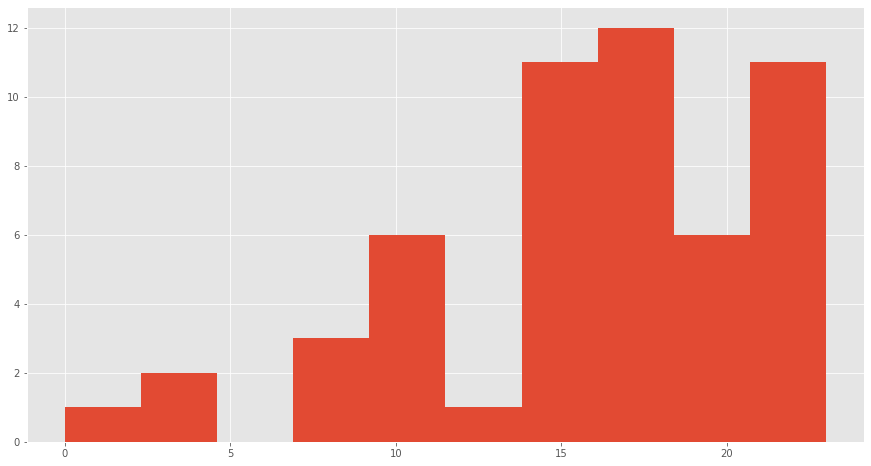

In [36]:
postp.hour.hist()

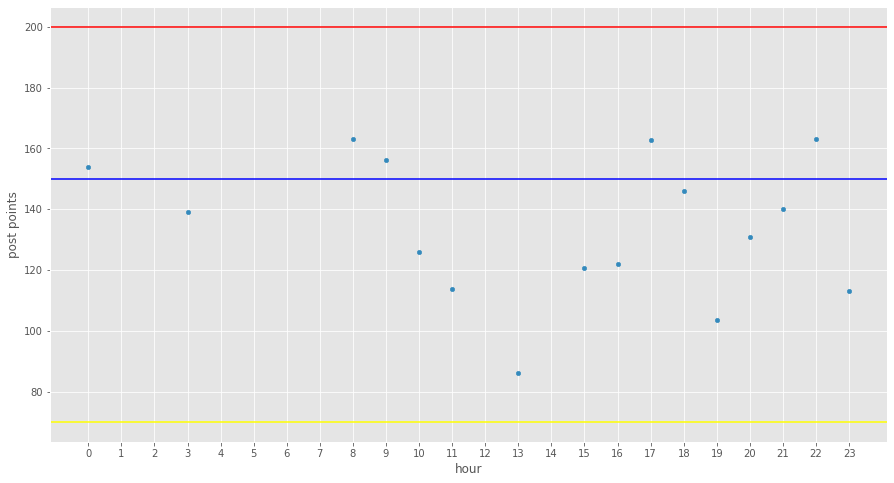

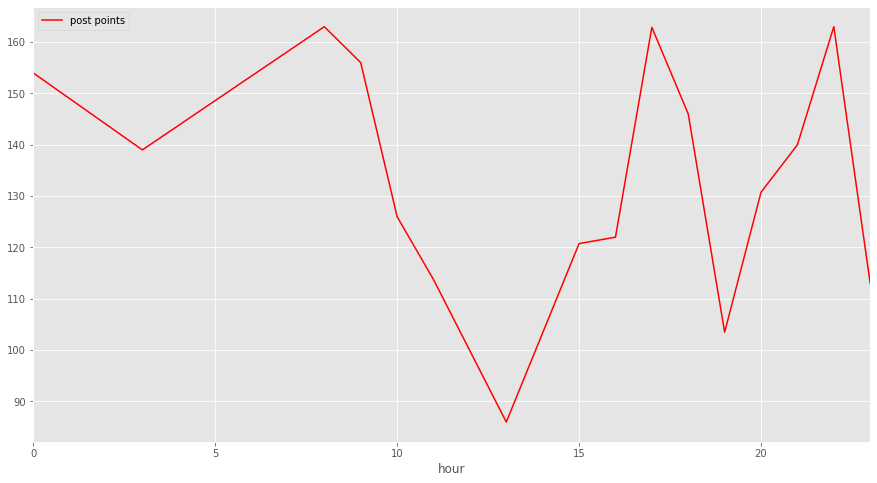

In [37]:
postp.groupby(postp.index.hour).mean().plot(
    x='hour', y='post points', kind='scatter', grid=True, xticks=list(range(24))
)
plt.axhline(150, color='blue')
plt.axhline(200, color='red')
plt.axhline(70, color='yellow')
postp.groupby(postp.index.hour).mean().plot(x='hour', y='post points', color='red')

In [38]:
y.groupby('hour')['Sensor Glucose (mg/dL)'].mean()

hour
0     145.605714
1     158.212291
2     181.031250
3     183.166667
4     177.031746
5     164.280000
6     155.830508
7     143.932961
8     144.068783
9     159.396648
10    166.978610
11    157.174863
12    152.214660
13    134.640625
14    125.203125
15    125.182320
16    125.954545
17    145.589474
18    161.913907
19    163.810127
20    159.018182
21    139.006024
22    126.615819
23    144.077778
Name: Sensor Glucose (mg/dL), dtype: float64

In [112]:
hourly_mean = y['Sensor Glucose (mg/dL)'].groupby(y.index.hour).mean()
hourly_std  = y['Sensor Glucose (mg/dL)'].groupby(y.index.hour).std()

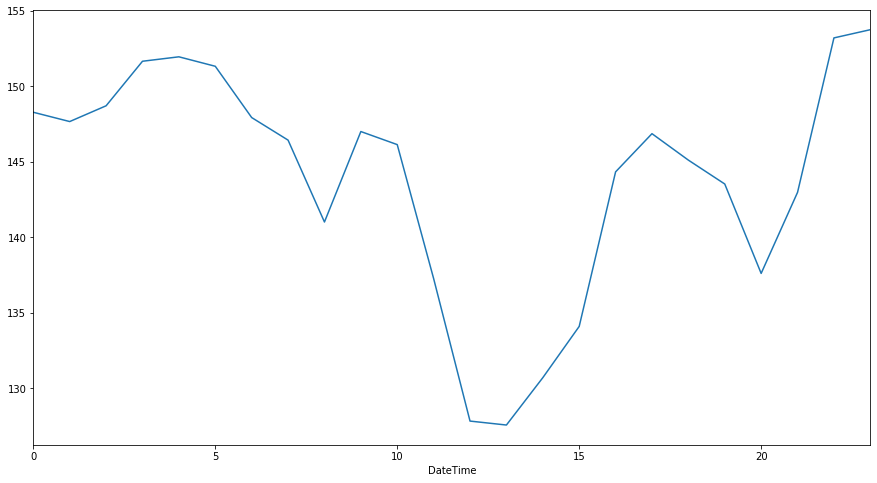

In [28]:
hourly_mean.plot()

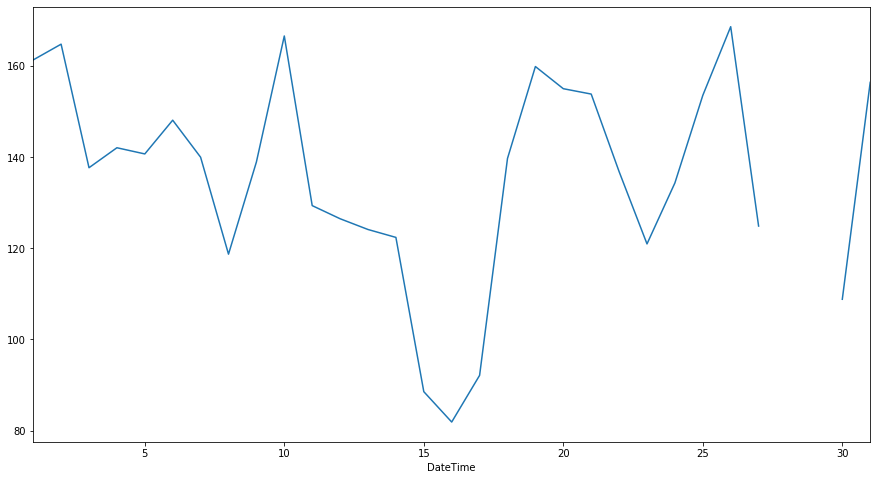

In [13]:
y['Sensor Glucose (mg/dL)'].groupby(y.index.day).mean().plot()

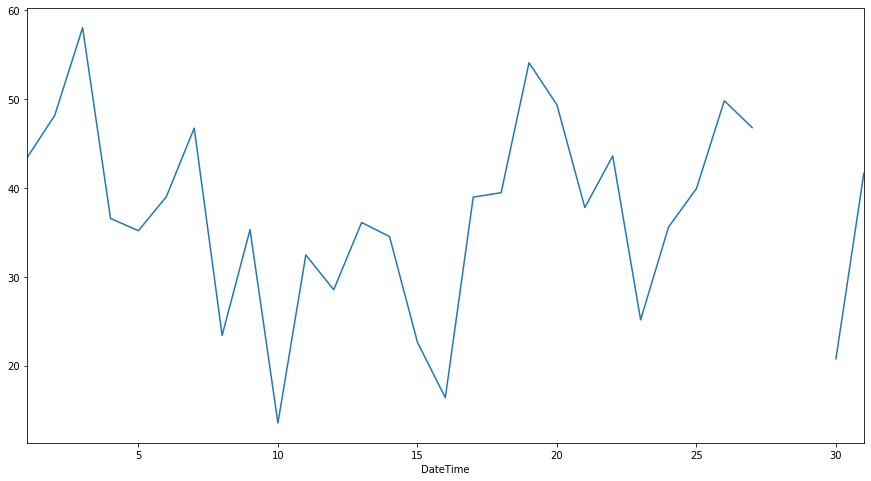

In [14]:
y['Sensor Glucose (mg/dL)'].groupby(y.index.day).std().plot()

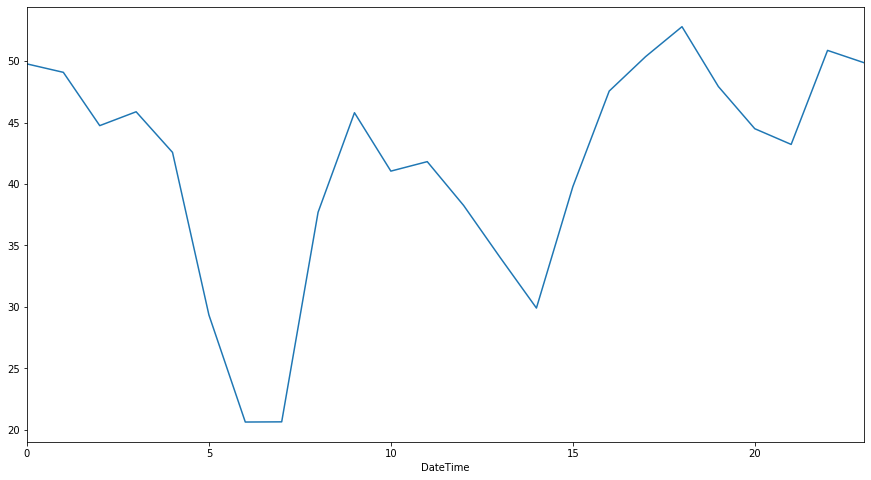

In [15]:
y['Sensor Glucose (mg/dL)'].groupby(y.index.hour).std().plot()

In [16]:
hourly_std.apply(lambda x: x/hourly_std.shape[0])

DateTime
0     2.073550
1     2.044991
2     1.864391
3     1.911366
4     1.773769
5     1.222983
6     0.860092
7     0.860734
8     1.570875
9     1.908137
10    1.710272
11    1.742381
12    1.593854
13    1.418132
14    1.246334
15    1.657384
16    1.981485
17    2.098222
18    2.199657
19    1.996871
20    1.853964
21    1.800740
22    2.119320
23    2.077687
Name: Sensor Glucose (mg/dL), dtype: float64

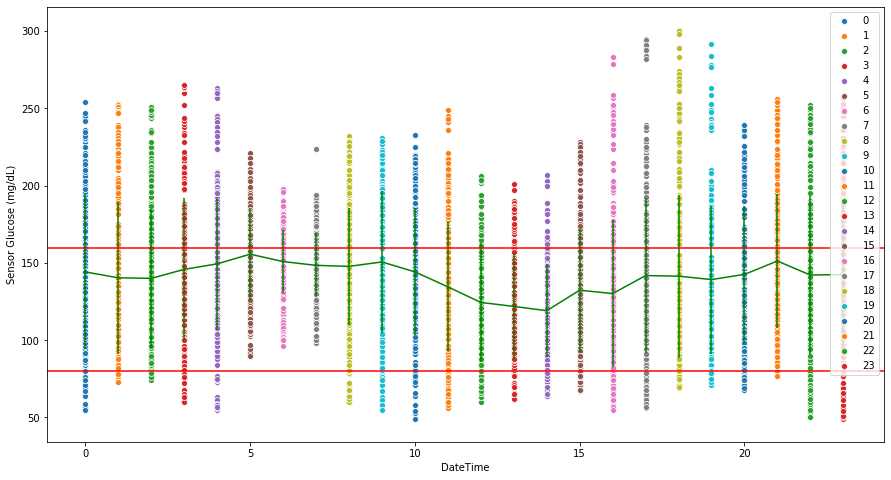

In [17]:
by_hour = y['Sensor Glucose (mg/dL)'].groupby(y.index.hour)
for i in by_hour:
    sns.scatterplot(i[1].dropna().index.hour, i[1].dropna(), label=f"{i[0]}")
    
plt.errorbar(
    hourly_mean.index, 
    hourly_mean.to_list(), 
    yerr=hourly_std.apply(lambda x: x).to_list(),
    c='green'
)

plt.axhline(160, c='red')
plt.axhline(80, c='red')

In [18]:
z = y['Sensor Glucose (mg/dL)'].groupby(y.index.hour)

In [19]:
for i in z:
    pass
    #sns.scatterplot(i[1].dropna().index.hour, i[1].dropna())
    #print(i[1].dropna())
    #plt.figure()
    #plt.title(f"Hour {i[0]}")
    #sns.distplot(i[1].dropna())

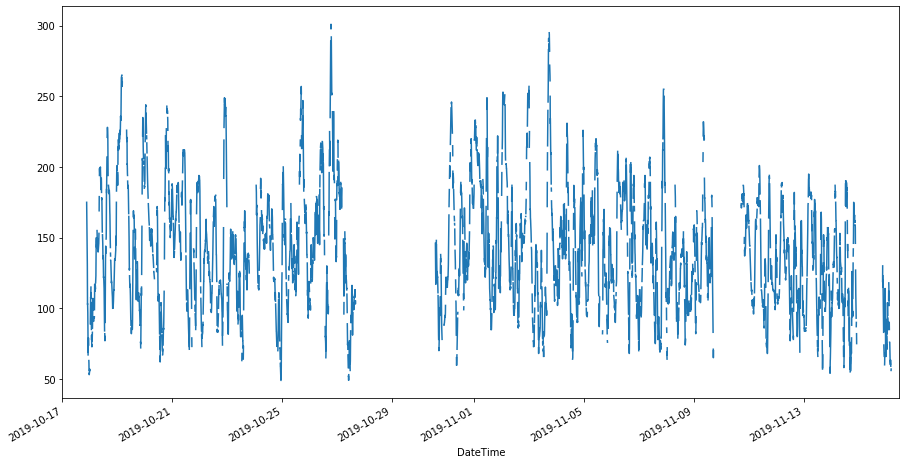

In [20]:
y['Sensor Glucose (mg/dL)'].plot()

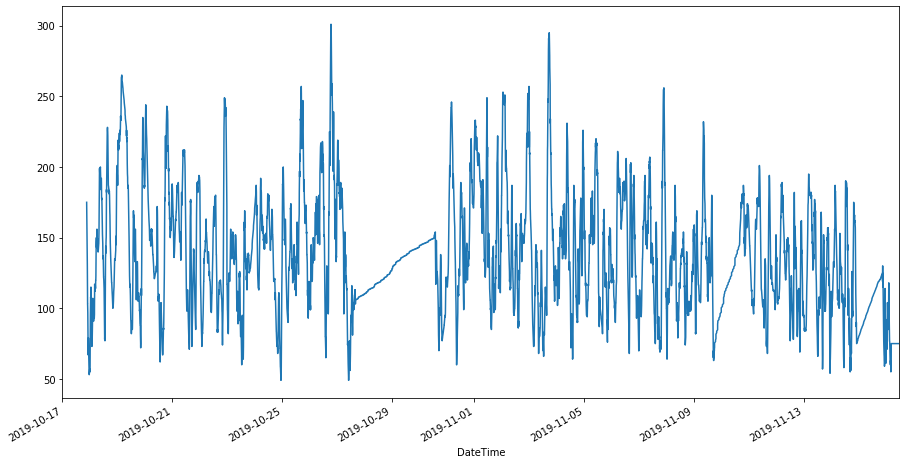

In [21]:
y['Sensor Glucose (mg/dL)'].interpolate().plot()

In [161]:
df = y['Sensor Glucose (mg/dL)']
df[np.bitwise_not(df.index.duplicated())]

DateTime
2019-10-17 00:00:00   NaN
2019-10-17 01:00:00   NaN
2019-10-17 01:11:00   NaN
2019-10-17 01:12:00   NaN
2019-10-17 02:00:00   NaN
                       ..
2019-11-16 10:50:46   NaN
2019-11-16 11:00:00   NaN
2019-11-16 11:09:43   NaN
2019-11-16 11:14:00   NaN
2019-11-16 11:46:13   NaN
Name: Sensor Glucose (mg/dL), Length: 9416, dtype: float64

In [174]:
time_series = y['Sensor Glucose (mg/dL)']
time_series =  time_series[~df.index.duplicated()].interpolate()
print(time_series.dropna().head(), '\n\n', y['Sensor Glucose (mg/dL)'].dropna())
#time_series.plot()
#decomp = seasonal_decompose(time_series)

DateTime
2019-10-17 21:15:55    169.0
2019-10-17 21:20:55    164.0
2019-10-17 21:25:55    158.0
2019-10-17 21:30:55    152.0
2019-10-17 21:35:55    143.0
Name: Sensor Glucose (mg/dL), dtype: float64 

 DateTime
2019-10-17 21:10:55    175.0
2019-10-17 21:15:55    169.0
2019-10-17 21:20:55    164.0
2019-10-17 21:25:55    158.0
2019-10-17 21:30:55    152.0
                       ...  
2019-11-16 04:17:47     55.0
2019-11-16 04:22:47     58.0
2019-11-16 04:27:47     56.0
2019-11-16 04:32:47     57.0
2019-11-16 04:37:47     75.0
Name: Sensor Glucose (mg/dL), Length: 6800, dtype: float64


In [148]:
help(seasonal_decompose)

Help on function seasonal_decompose in module statsmodels.tsa.seasonal:

seasonal_decompose(x, model='additive', filt=None, freq=None, two_sided=True, extrapolate_trend=0)
    Seasonal decomposition using moving averages
    
    Parameters
    ----------
    x : array-like
        Time series. If 2d, individual series are in columns.
    model : str {"additive", "multiplicative"}
        Type of seasonal component. Abbreviations are accepted.
    filt : array-like
        The filter coefficients for filtering out the seasonal component.
        The concrete moving average method used in filtering is determined by two_sided.
    freq : int, optional
        Frequency of the series. Must be used if x is not a pandas object.
        Overrides default periodicity of x if x is a pandas
        object with a timeseries index.
    two_sided : bool
        The moving average method used in filtering.
        If True (default), a centered moving average is computed using the filt.
        If F